Based on: https://github.com/patrickloeber/pytorchTutorial/blob/master/14_cnn.py

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [30]:
# Device configuration
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Using GPU')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
  print('Using MPS')
else:
  device = torch.device('cpu')
  print('Using CPU')

device = torch.device('cpu')

Using MPS


In [31]:
# Hyper-parameters 
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


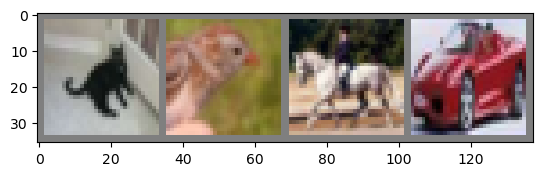

In [32]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [38]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [39]:
num_epochs = 5

n_total_steps = len(train_loader)
loss_list = []

start_time = time.time()

for epoch in range(num_epochs):
  running_loss = 0.0
  epoch_time = time.time()
  for i, (images, labels) in enumerate(train_loader):
    
    # origin shape: [4, 3, 32, 32] = 4, 3, 1024
    # input_layer: 3 input channels, 6 output channels, 5 kernel size
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if (i + 1) % 2000 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], \tStep [{i+1}/{n_total_steps}], \tLoss: {loss.item():.4f})')
  
  epoch_loss = running_loss / n_total_steps
  loss_list.append(epoch_loss)

  elapsed_time = time.time() - epoch_time
  print(f'Epoch Time: {elapsed_time:.2f} seconds')

end_time = time.time()
execution_time = end_time - start_time
print(f'Finished Training in {execution_time:.2f} seconds')

PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], 	Step [2000/12500], 	Loss: 2.2849)
Epoch [1/5], 	Step [4000/12500], 	Loss: 2.2775)
Epoch [1/5], 	Step [6000/12500], 	Loss: 2.3062)
Epoch [1/5], 	Step [8000/12500], 	Loss: 2.2555)
Epoch [1/5], 	Step [10000/12500], 	Loss: 1.8447)
Epoch [1/5], 	Step [12000/12500], 	Loss: 1.8170)
Epoch Time: 23.34 seconds
Epoch [2/5], 	Step [2000/12500], 	Loss: 2.2934)
Epoch [2/5], 	Step [4000/12500], 	Loss: 2.0704)
Epoch [2/5], 	Step [6000/12500], 	Loss: 2.0577)
Epoch [2/5], 	Step [8000/12500], 	Loss: 1.0726)
Epoch [2/5], 	Step [10000/12500], 	Loss: 1.3899)
Epoch [2/5], 	Step [12000/12500], 	Loss: 1.2513)
Epoch Time: 23.40 seconds
Epoch [3/5], 	Step [2000/12500], 	Loss: 2.0522)
Epoch [3/5], 	Step [4000/12500], 	Loss: 1.8666)
Epoch [3/5], 	Step [6000/12500], 	Loss: 1.5435)
Epoch [3/5], 	Step [8000/12500], 	Loss: 1.0261)
Epoch [3/5], 	Step [10000/12500], 	Loss: 1.3448)
Epoch [3/5], 	Step [12000/12500], 	Loss: 0.5557)
Epoch Time: 22.45 seconds
Epoch [4/5], 	Step [2000/12500], 	Loss: 1.3189)
Epoc

- Apple silicon @ 4: Finished Training in 8829.70 seconds
- Apple silicon @ 16: Finished Training in 2818.96 seconds
- CUDA @ 4: Finished Training in 10554.78 seconds

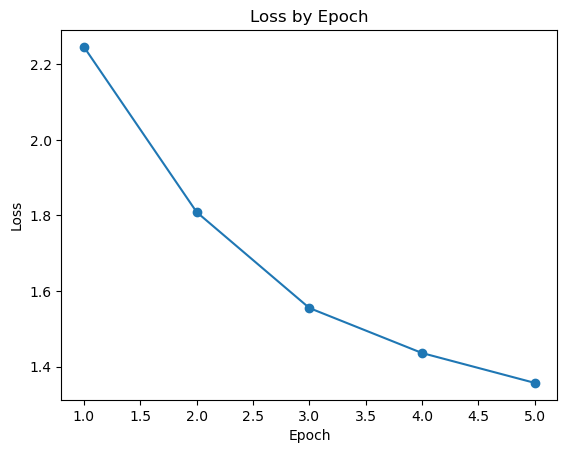

In [40]:
# Plotting the loss
plt.plot(range(1, num_epochs + 1), loss_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.show()

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
    
    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')
